# Modeling True Positive and True Negative rates

We want to use the Bivariate Beta distribution built in the previous
sections. Before integrating it to the whole model, we consider a model for
sensibility and sensitivity as follows: 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ individuals who
were exposed to a disease, and $Y_n$ denote the number of negative tests in
$n_{neg}$ not exposed. The person is tested with a gold standard, which is the
best benchmark and the most accurate possible.

Remind that the sensitivity $\gamma_s$ is the probability of a test being positive given
the exposition, while the specificity $\gamma_e$ is the probability of a
negative test given the non-exposition. 
Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$. 
Besides that, there are two different models to handle with
$\alpha = (\alpha_1, \dots, \alpha_4)$. 

I. $\alpha_i \sim \operatorname{Gamma}(a^i, b^i)$, with $a^i$ and $b^i$ fixed. 

II. $\alpha_i \sim \operatorname{Dirac}(\hat{\alpha}_i)$ such that $\hat{\alpha}_i$
is calculated as explained before. 

In [1]:
import numpy as np
import pystan as ps

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

## Model 

First we code the model in Stan and use PyStan as a Python interface. 

In [43]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data and parameter blocks

Observe that we have a boolean variable to distinguish both models. 

In [3]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}' + structure[2]+'}') 

data {
    int<lower = 0> n_pos;
    int<lower = 0> n_neg; 
    int Y_p;
    int Y_n;
    vector<lower = 0>[4] alpha_data;
}
parameters {
    simplex[4] U; 
}
transformed parameters{ 
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec; 
    sens = U[1] + U[2];
    spec = U[1] + U[3];
}


### Model block 

In [4]:
print(structure[3] + '}') 


model {
    U ~ dirichlet(alpha_data);
    Y_p ~ binomial(n_pos, sens);
    Y_n ~ binomial(n_neg, spec);
}


## Toy example 

First we need to test the model with fake data. This is done to verify how the it behaves in a controlled space. 

In [5]:
n_pos = 50
n_neg = 45

sens = 0.8 
spec = 0.9

Y_p = np.random.binomial(n = n_pos, p = sens)
Y_n = np.random.binomial(n = n_neg, p = spec)

m1, m2, v1, v2, rho = sens, spec, (0.05)**2, (0.05)**2, -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho, c = [1,1,1,1])

Notice that the estimated values are below: 

In [6]:
BivariateBeta().moments_calculus(solution.x)

(0.7605622599670436,
 0.8451216472124901,
 0.0028470020826766042,
 0.00204630495469627,
 -0.2401953043476225)

In [48]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": solution.x
}

In [49]:
fit = sm.sampling(data=data, iter=5000)

In [50]:
fit

Inference for Stan model: anon_model_283154543b71871021ef1d48f344f3a6.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean      sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
U[1]          0.62  8.5e-4    0.05    0.52    0.59    0.62   0.65   0.72   3350    1.0
U[2]          0.17  6.2e-4    0.04     0.1    0.14    0.16   0.19   0.24   3285    1.0
U[3]          0.21  6.5e-4    0.04    0.14    0.19    0.21   0.24   0.29   3433    1.0
U[4]        4.6e-4  3.7e-5  2.5e-3 5.6e-17 1.6e-13 6.4e-10 2.2e-6 5.2e-3   4615    1.0
sens          0.79  6.5e-4    0.04    0.71    0.76    0.79   0.81   0.86   3433    1.0
spec          0.83  6.2e-4    0.04    0.76    0.81    0.83   0.86    0.9   3290    1.0
U_prior[1]    0.61  6.2e-4    0.06    0.48    0.56    0.61   0.65   0.72   9502    1.0
U_prior[2]    0.15  4.5e-4    0.05    0.08    0.12    0.15   0.18   0.25  10182    1.0
U_prior[3]    0.24  5.4e-4 

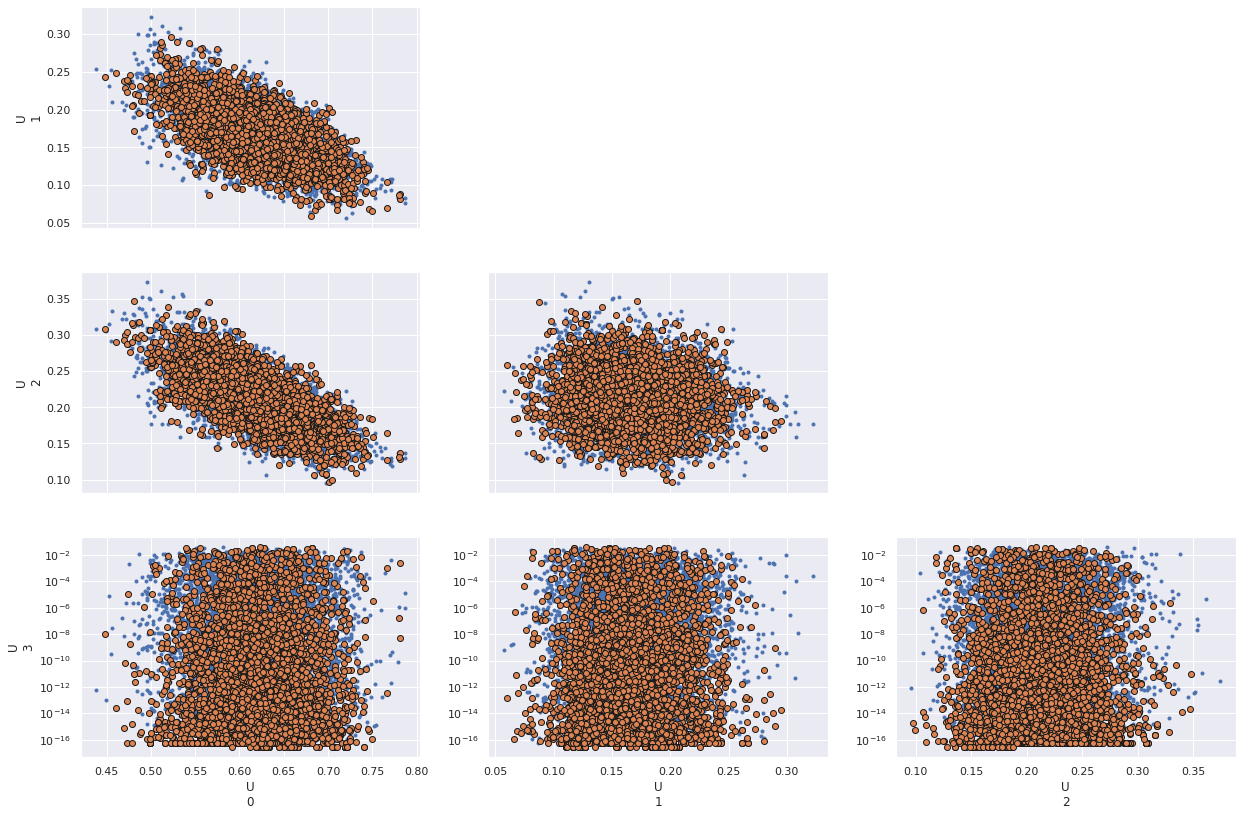

In [51]:
inference_data = az.convert_to_inference_data(fit)
ax = az.plot_pair(inference_data, var_names=('U'), divergences=True, group = 'posterior')
for i in range(3): ax[2][i].set_yscale('log')
plt.show()

Here we use a modification explained in [here]()

In [55]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [12]:
fit = sm.sampling(data=data, iter=5000, chains=4)

In [13]:
fit

Inference for Stan model: anon_model_687ec2a1287966d2c97ca899ce20f61c.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean      sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
Z[1]          0.38  6.9e-4    0.05    0.29    0.35   0.38   0.41   0.48   5036    1.0
Z[2]          0.56  1.1e-3    0.07    0.41    0.51   0.56   0.61    0.7   4785    1.0
Z[3]        1.8e-3  1.2e-4 10.0e-3 2.2e-16 5.5e-13 2.1e-9 8.9e-6   0.02   7446    1.0
sens          0.79  5.4e-4    0.04    0.71    0.76   0.79   0.81   0.86   4999    1.0
spec          0.83  5.4e-4    0.04    0.75    0.81   0.83   0.86    0.9   4738    1.0
Z_prior[1]    0.39  6.1e-4    0.06    0.28    0.35   0.39   0.43   0.52  10041    1.0
Z_prior[2]    0.61  9.5e-4     0.1    0.41    0.54   0.61   0.68   0.79  10094    1.0
Z_prior[3] 1.3e-43     nan 1.3e-41     0.0     0.0    0.0    0.0    0.0    nan    1.0
sens_prior    0.76  5.2e-4    0.05  

> Why is this happening? 

Let's see what is $Z_3$! Below are the only non-zero samples!

In [14]:
samples = fit.extract()['Z_prior'][:,2]
samples = samples[samples != 0]
samples

array([4.59571658e-186, 4.68556059e-261, 5.90673535e-175, 2.25333572e-123,
       1.26895638e-039, 5.16273100e-252])

And the 0.9999-quartile is `1e-55`, that is, the probability mass is all in zero! This happens because $b \gg a$. 

In [16]:
from scipy.stats import beta as beta_dist

z_3 = beta_dist(a = solution.x[-1], b = solution.x[-2])
z_3.ppf(0.9999)

1.4222706865628329e-55

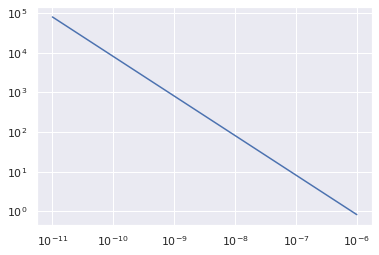

In [17]:
t = np.linspace(0,1e-6,100000)

plt.plot(t, z_3.pdf(t))
plt.xscale('log')
plt.yscale('log')

Now that we understand a bit more about the problem, let's try to change a little bit the lower bound in $\alpha_4$. 

In [56]:
alpha_hat = ParameterAlpha().mix_solver(m1,m2,v1,v2,rho, lb = 0.00001)

In [57]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": alpha_hat
}

In [67]:
fit = sm.sampling(data=data, iter=5000, pars = ('sens', 'spec', 'sens_prior', 'spec_prior'))
summary = az.summary(fit)

In [68]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sens,0.814,0.038,0.744,0.886,0.001,0.0,5155.0,4359.0,1.0
spec,0.862,0.035,0.793,0.923,0.001,0.0,4892.0,5339.0,1.0
sens_prior,0.800,0.056,0.694,0.899,0.001,0.0,9825.0,9085.0,1.0
spec_prior,0.900,0.042,0.822,0.972,0.000,0.0,9695.0,9497.0,1.0


array([[<AxesSubplot:title={'center':'spec'}>,
        <AxesSubplot:title={'center':'spec'}>],
       [<AxesSubplot:title={'center':'sens'}>,
        <AxesSubplot:title={'center':'sens'}>]], dtype=object)

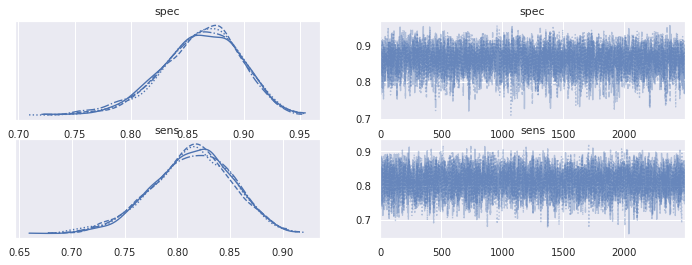

In [70]:
az.plot_trace(fit, var_names=('spec', 'sens'))

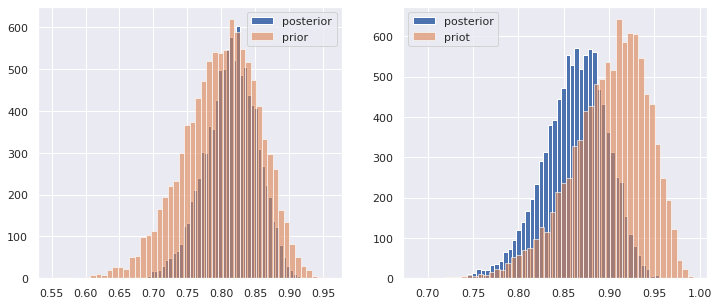

In [80]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

ax[0].hist(fit.extract()['sens'], label = 'posterior', bins = 50)
ax[1].hist(fit.extract()['spec'], label = 'posterior', bins = 50)
ax[0].hist(fit.extract()['sens_prior'], label = 'prior', alpha = 0.6, bins = 50)
ax[1].hist(fit.extract()['spec_prior'], label = 'priot', alpha = 0.6, bins = 50)

ax[0].legend()
ax[1].legend()

plt.show()

Is the posterior removing some correlation?

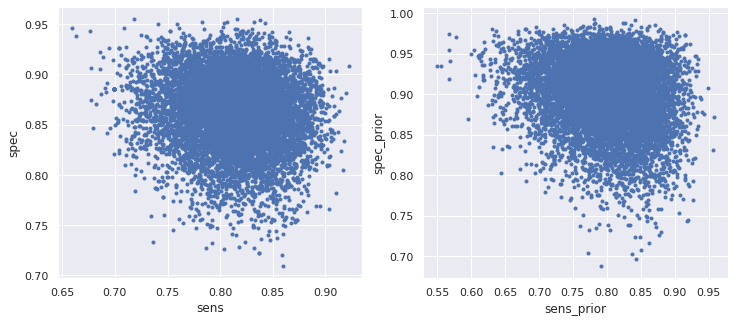

In [86]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
az.plot_pair(fit, var_names=('sens', 'spec'), ax = ax[0])
az.plot_pair(fit, var_names=('sens_prior', 'spec_prior'), ax = ax[1])
plt.show()

In [92]:
print('Prior correlation:')
print(np.corrcoef(fit.extract()['spec_prior'], fit.extract()['sens_prior'])[0,1])
print('Posterior correlation:')
print(np.corrcoef(fit.extract()['spec'], fit.extract()['sens'])[0,1])

Prior correlation:
-0.1699618665163714
Posterior correlation:
-0.10867968447259903
